<a href="https://colab.research.google.com/github/pyreyes/emotion_detection/blob/main/Scratch_Model_and_SVM_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os

drive.mount('/content/gdrive')

os.chdir('gdrive/My Drive/Facial_Recognition')


Mounted at /content/gdrive


## Import Library

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
# Importing sklearn libraries
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
 
# # Importing hypopt library for grid search
# !pip install hypopt
# from hypopt import GridSearch
 
# Importing Keras libraries
from keras.utils import np_utils
from keras.models import Sequential, save_model, load_model
from keras.applications import VGG16
from keras.applications import imagenet_utils
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, EarlyStopping
from keras.preprocessing.image import load_img, ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing import image_dataset_from_directory
from keras.layers import Dense, Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Dropout, Flatten, GlobalAveragePooling2D


# from keras.applications import VGG19
# from keras.applications import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.regularizers import l2
from keras.optimizers import Adam
import seaborn as sns
 
import warnings
warnings.filterwarnings('ignore')

## Define functions and load dataset

In [ ]:
def getPic(img_path):
    return np.array(Image.open(img_path).convert('L').resize((48,48),Image.ANTIALIAS))

def get_label(img_path):
    return Path(img_path).parts[2][0:3]

def get_ds(data_path):
    img_paths = list()
    # Recursively find all the image files from the path data_path
    for img_path in glob.glob(data_path+"/**/*"):
        img_paths.append(img_path)
    images = np.zeros((len(img_paths),48,48))
    labels = np.zeros(len(img_paths))
    # Read and resize the images
    # Get the encoded labels
    for i, img_path in tqdm(enumerate(img_paths)):
        images[i] = getPic(img_path)
        labels[i] = label_to_index[get_label(img_path)]
        
    return images,labels

In [ ]:
labels = ["angry", "disgust", "fear", "happy", "neutral", "sad", "suprise"]

# This function calcules the prediction for a given image give the image path and a model
def return_prediction(path, model):
    img = Image.open(path)
    label = Path(path).parts[len(Path(path).parts)-2]
    data_X = getPic(path)   
    data_X = np.expand_dims(np.expand_dims(data_X, -1),-4)
    data_X = data_X / 255.
    # img = np.repeat(img[..., np.newaxis], 3, -1)

    plt.style.use('classic')

    fig = plt.figure(figsize=(10,5), constrained_layout=True)
    gs = fig.add_gridspec(3, 3)
    a0 = fig.add_subplot(gs[0:,:2])
    a1 = fig.add_subplot(gs[1:,2])
    a3 = fig.add_subplot(gs[0,2])
    a0.imshow(img)

    pred_prob =  model.predict(data_X)
    pred_label = np.argmax(pred_prob)

    a1.set_title('Predicted Probability')
    a1.barh(labels, pred_prob[0], align='center', alpha=0.5)
    a3.text(0.5, 0.5, 'Actual: ' +label, size=16, ha='center', va='center')
    a3.axis('off')
    a0.axis('off')
    fig.set_facecolor((1,1,1))
    plt.show()

#this function prints the accuracy, presision and recall matrices given the predicted and actual values
def return_confusion_matrix(actual_label, predicted_label):
    confusionMatrix = confusion_matrix(actual_label, predicted_label, labels=range(0,7))
    precision = confusionMatrix/confusionMatrix.sum(axis = 0)
    recall = (confusionMatrix.T/confusionMatrix.sum(axis = 1)).T
    
    sns.set(font_scale=1)
    
    plt.figure(figsize=(8,3))
    sns.heatmap(confusionMatrix, cmap = "Blues", annot = True, fmt = ".0f", xticklabels=labels, yticklabels=labels)
    plt.title("Confusion Matrix", fontsize = 20)
    plt.xlabel('Predicted Label', fontsize = 12)
    plt.ylabel('Actual Label', fontsize = 12)
    plt.tick_params(labelsize = 13)
    plt.xticks(rotation = 60)
    plt.show()

    plt.figure(figsize=(8,3))
    sns.heatmap(precision, cmap = "Blues", annot = True, fmt = ".1%", xticklabels=labels, yticklabels=labels)
    plt.title("Precision Matrix", fontsize = 20)
    plt.xlabel('Predicted Label', fontsize = 12)
    plt.ylabel('Actual Label', fontsize = 12)
    plt.tick_params(labelsize = 13)
    plt.xticks(rotation = 60)
    plt.show()

    plt.figure(figsize=(8,3))
    sns.heatmap(recall, cmap = "Blues", annot = True, fmt = ".1%", xticklabels=labels, yticklabels=labels)
    plt.title("Recall Matrix", fontsize = 20)
    plt.xlabel('Predicted Label', fontsize = 12)
    plt.ylabel('Actual Label', fontsize = 12)
    plt.tick_params(labelsize = 13)
    plt.xticks(rotation = 60)
    plt.show()

In [ ]:
def create_features(x, pre_model):
    features = pre_model.predict(x, batch_size=32)
    print(features.shape)
    features_flatten = features.reshape((features.shape[0], 1 * 1 * 512))
    # features_flatten = features.reshape((features.shape[0], 2 * 2 * 2048))
    return features, features_flatten

In [ ]:
train_X = np.load('np_data/train_X.npy')
train_X = np.expand_dims(train_X, -1)
test_X = np.load('np_data/test_X.npy')
test_X = np.expand_dims(test_X, -1)

train_X = train_X / 255.
test_X = test_X /255.

num_classes = 7
train_y = np.load('np_data/train_y.npy')
test_y = np.load('np_data/test_y.npy')

#Set aside validation set from test
test_X, validation_X, test_y, validation_y = train_test_split(test_X, test_y, test_size=0.6, random_state=23)

y_train = np_utils.to_categorical(train_y, num_classes)
y_test = np_utils.to_categorical(test_y, num_classes)
y_validation = np_utils.to_categorical(validation_y, num_classes)



## SVM Transfer Models

In [ ]:
#Load VGG16 model
VGG16_model = VGG16(weights="imagenet", include_top=False, input_shape=(48,48,3))

VGG_train_X = np.repeat(train_X[...], 3, 3)
VGG_test_X =  np.repeat(test_X[...], 3, 3)

#Extract features
train_features, train_features_flatten = create_features(VGG_train_X, VGG16_model)
test_features, test_features_flatten = create_features(VGG_test_X, VGG16_model)

(28709, 1, 1, 512)
(2871, 1, 1, 512)


### Linear SVM

In [ ]:
from sklearn.svm import LinearSVC

linear_svm = LinearSVC().fit(train_features_flatten,train_y) 


Accuracy on Test Data:  0.41274817136886105


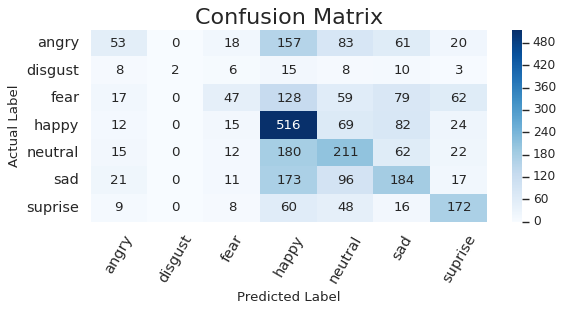

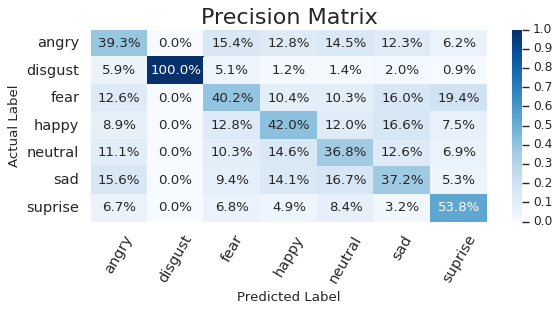

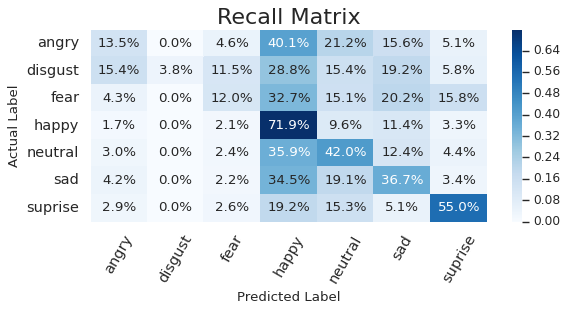

In [ ]:
preds = linear_svm.predict(test_features_flatten)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
return_confusion_matrix(test_y,preds)

### RBF Kernel SVM

In [ ]:
from sklearn.svm import SVC 

svm_rbf = SVC(kernel = 'rbf').fit(train_features_flatten, train_y) 


Accuracy on Test Data:  0.4235458028561477


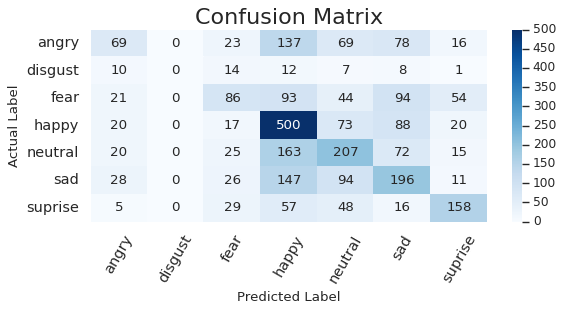

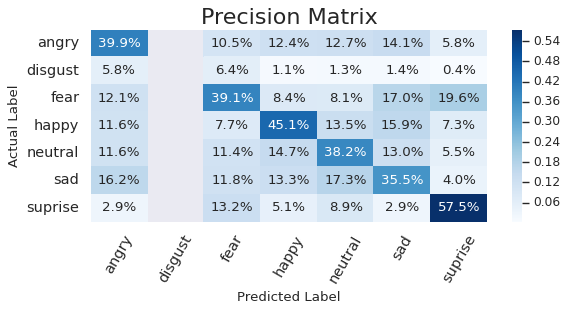

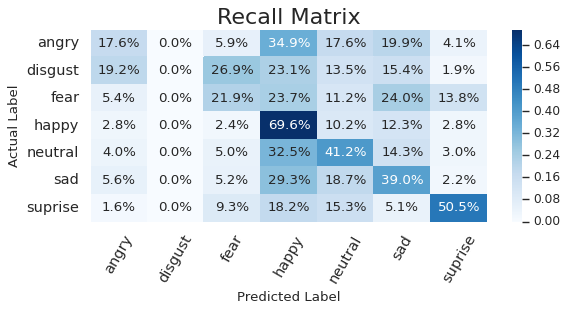

In [ ]:
preds = svm_rbf.predict(test_features_flatten)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
return_confusion_matrix(test_y,preds)

### Polinomial Kernel SVM

In [ ]:
from sklearn.svm import SVC 

svm_poly = SVC(kernel = 'poly').fit(train_features_flatten, train_y) 


Accuracy on Test Data:  0.4385231626610937


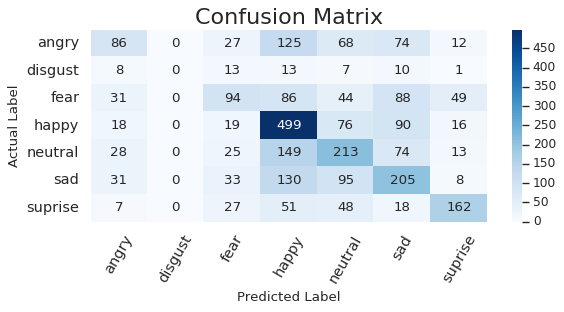

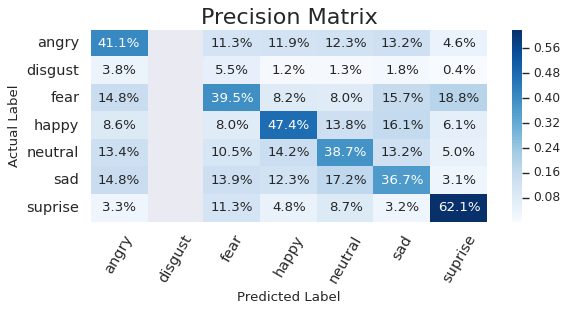

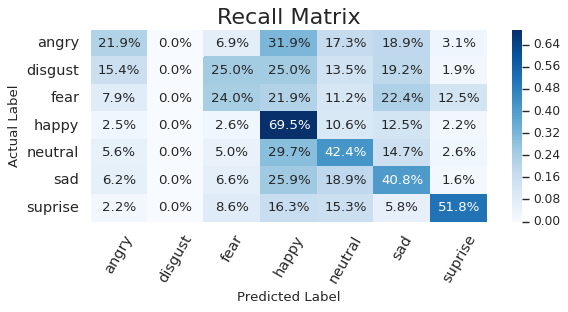

In [ ]:
preds = svm_poly.predict(test_features_flatten)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
return_confusion_matrix(test_y,preds)

## CNN from Scratch.

### Define model architecture

In [ ]:
num_of_filters = 32
model = Sequential()

model.add(Conv2D(filters=num_of_filters, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))

model.add(Conv2D(num_of_filters, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(2*num_of_filters, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_of_filters, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(2*2*num_of_filters, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_of_filters, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Conv2D(2*2*2*num_of_filters, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_of_filters, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

model.add(Flatten())

model.add(Dense(2*2*2*num_of_filters, activation='relu'))
model.add(Dense(2*2*num_of_filters, activation='relu'))
model.add(Dense(2*num_of_filters, activation='relu'))

model.add(Dense(7, activation='softmax'))
model.summary()

initial_weights = model.get_weights()
# model.load_weights('model.lab4.hdf5')

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 46, 46, 32)        9248      
_________________________________________________________________
batch_normalization_35 (Batc (None, 46, 46, 32)        128       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 23, 23, 64)        18496     
_________________________________________________________________
batch_normalization_36 (Batc (None, 23, 23, 64)        256       
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 23, 23, 64)       

### Train base model

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

#reduce learning rate when loss on validation set has stopped improving
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=3, verbose=1)

#stop training when loss on validation set has stopped improving
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath='model.lab4.hdf5',
                               verbose=1,save_best_only=True, monitor='val_loss')

history = model.fit(train_X, y_train,
          batch_size=32,
          epochs=40,
          verbose=1,
          validation_data=(validation_X, y_validation),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])

Epoch 1/40
891/898 [============================>.] - ETA: 0s - loss: 1.5563 - accuracy: 0.3843
Epoch 00001: val_loss improved from inf to 1.46272, saving model to model.lab4.hdf5
898/898 [==============================] - 6s 7ms/step - loss: 1.5549 - accuracy: 0.3850 - val_loss: 1.4627 - val_accuracy: 0.4254
Epoch 2/40
891/898 [============================>.] - ETA: 0s - loss: 1.2414 - accuracy: 0.5264
Epoch 00002: val_loss improved from 1.46272 to 1.34353, saving model to model.lab4.hdf5
898/898 [==============================] - 6s 6ms/step - loss: 1.2410 - accuracy: 0.5264 - val_loss: 1.3435 - val_accuracy: 0.5124
Epoch 3/40
898/898 [==============================] - ETA: 0s - loss: 1.1100 - accuracy: 0.5808
Epoch 00003: val_loss improved from 1.34353 to 1.24285, saving model to model.lab4.hdf5
898/898 [==============================] - 6s 6ms/step - loss: 1.1100 - accuracy: 0.5808 - val_loss: 1.2429 - val_accuracy: 0.5322
Epoch 4/40
894/898 [============================>.] - ETA: 


Accuracy on Test Data:  0.632183908045977


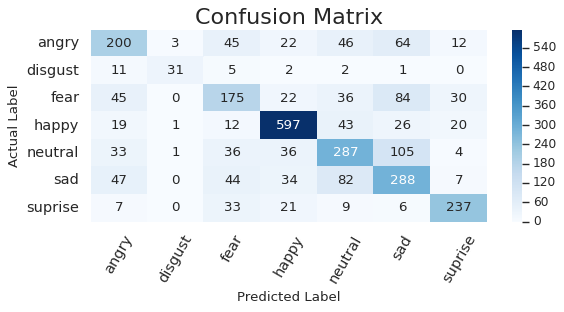

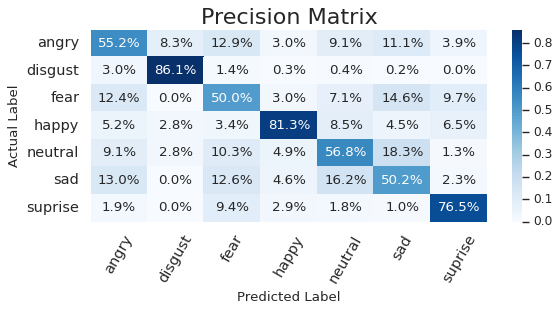

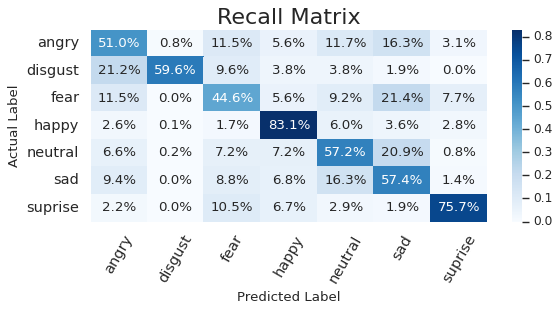

In [ ]:
preds = np.argmax(model.predict(test_X), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))

return_confusion_matrix(test_y,preds)

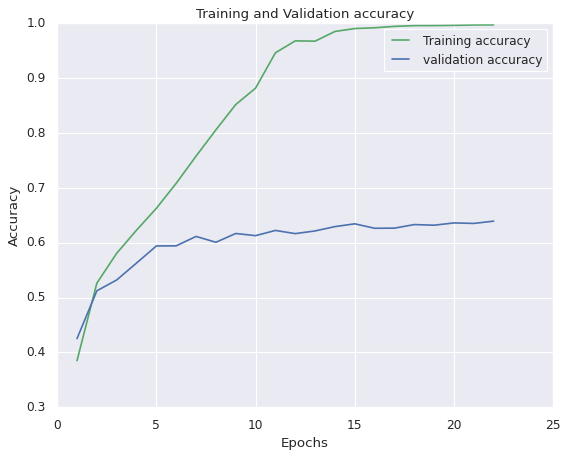

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,len(acc_train)+1)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()


### Add data augmentation.

In [ ]:
datagen = ImageDataGenerator(rotation_range=35, horizontal_flip=0.5)
train_gen = datagen.flow(train_X, y_train, batch_size=32)

model = model
model.set_weights(initial_weights)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

# reduce learning rate when loss on validation set has stopped improving
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=3, verbose=1)

#stop training when loss on validation set has stopped improving
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath='model.lab32.hdf5',
                               verbose=1,save_best_only=True, monitor='val_loss')

history = model.fit(train_gen,
          epochs=40,
          verbose=1,
          validation_data=(validation_X, y_validation),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])



Epoch 1/40
896/898 [============================>.] - ETA: 0s - loss: 1.6682 - accuracy: 0.3307
Epoch 00001: val_loss improved from inf to 1.54788, saving model to model.lab32.hdf5
898/898 [==============================] - 11s 12ms/step - loss: 1.6676 - accuracy: 0.3310 - val_loss: 1.5479 - val_accuracy: 0.3873
Epoch 2/40
897/898 [============================>.] - ETA: 0s - loss: 1.3848 - accuracy: 0.4648
Epoch 00002: val_loss improved from 1.54788 to 1.31450, saving model to model.lab32.hdf5
898/898 [==============================] - 11s 12ms/step - loss: 1.3849 - accuracy: 0.4647 - val_loss: 1.3145 - val_accuracy: 0.4941
Epoch 3/40
897/898 [============================>.] - ETA: 0s - loss: 1.2665 - accuracy: 0.5164
Epoch 00003: val_loss improved from 1.31450 to 1.21060, saving model to model.lab32.hdf5
898/898 [==============================] - 11s 12ms/step - loss: 1.2665 - accuracy: 0.5165 - val_loss: 1.2106 - val_accuracy: 0.5342
Epoch 4/40
894/898 [============================>.


Accuracy on Test Data:  0.6666666666666666


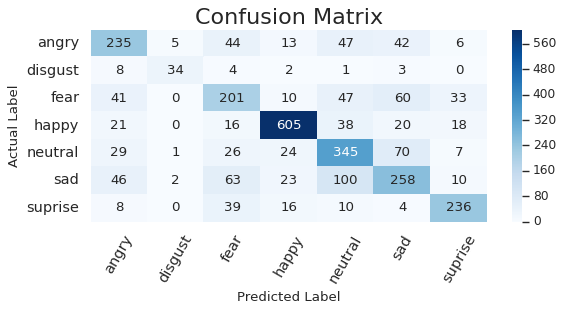

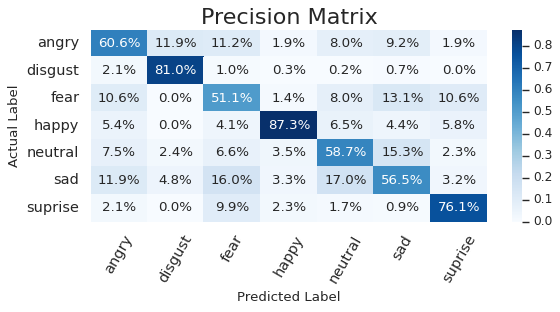

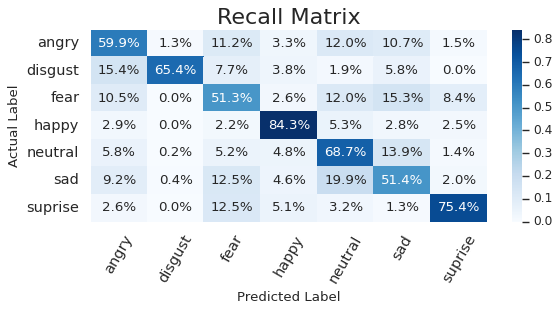

In [ ]:
preds = np.argmax(model.predict(test_X), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
return_confusion_matrix(test_y,preds)

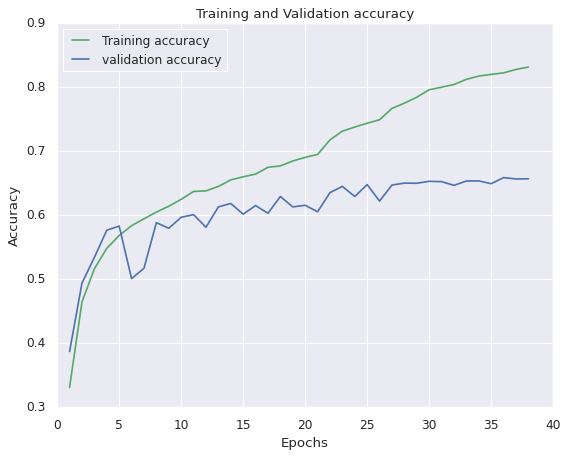

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,len(acc_train)+1)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

### Apply SMOTE

In [ ]:
#Create a new SMOTE dataset.
from imblearn.over_sampling import SMOTE

train_smote_X = np.load('np_data/train_X.npy')
train_smote_X = train_smote_X.flatten()
train_smote_X = train_smote_X.reshape(train_X.shape[0], -1)
train_smote_X.shape
sm = SMOTE(random_state=23)
X_smote, y_smote = sm.fit_resample(train_smote_X, train_y)
np.save('np_data/X_smote.npy', X_smote)
np.save('np_data/y_smote.npy', y_smote)

In [ ]:
#load SMOTE dataset 
X_smote = np.load('np_data/X_smote.npy')
y_smote = np.load('np_data/y_smote.npy')
smote_X = X_smote.reshape(-1, 48,48)
smote_X = np.expand_dims(smote_X, -1)

smote_X = smote_X / 255.

smote_datagen = ImageDataGenerator(#rescale= 1./255,
                                   rotation_range=35, 
                                   horizontal_flip=0.5
                                   )

smote_y = np_utils.to_categorical(y_smote, num_classes)

train_smote_gen = smote_datagen.flow(smote_X, smote_y,batch_size=32)

In [ ]:
model = model
model.set_weights(initial_weights)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

# reduce learning rate when loss on validation set has stopped improving
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=3, verbose=1)

#stop training when loss on validation set has stopped improving
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath='model.lab31.hdf5',
                               verbose=1,save_best_only=True, monitor='val_loss')

history = model.fit(train_smote_gen,
          epochs=40,
          verbose=1,
          validation_data=(validation_X, y_validation),
          shuffle=True,
          callbacks=[lr_reducer, early_stopper, checkpointer])

Epoch 1/40
1575/1579 [============================>.] - ETA: 0s - loss: 1.6317 - accuracy: 0.3582
Epoch 00001: val_loss improved from inf to 1.41035, saving model to model.lab31.hdf5
1579/1579 [==============================] - 18s 11ms/step - loss: 1.6311 - accuracy: 0.3584 - val_loss: 1.4103 - val_accuracy: 0.4653
Epoch 2/40
1577/1579 [============================>.] - ETA: 0s - loss: 1.2564 - accuracy: 0.5206
Epoch 00002: val_loss improved from 1.41035 to 1.33035, saving model to model.lab31.hdf5
1579/1579 [==============================] - 18s 11ms/step - loss: 1.2563 - accuracy: 0.5206 - val_loss: 1.3303 - val_accuracy: 0.4990
Epoch 3/40
1576/1579 [============================>.] - ETA: 0s - loss: 1.1216 - accuracy: 0.5762
Epoch 00003: val_loss improved from 1.33035 to 1.26733, saving model to model.lab31.hdf5
1579/1579 [==============================] - 18s 11ms/step - loss: 1.1217 - accuracy: 0.5762 - val_loss: 1.2673 - val_accuracy: 0.5187
Epoch 4/40
1578/1579 [================


Accuracy on Test Data:  0.6576105886450714


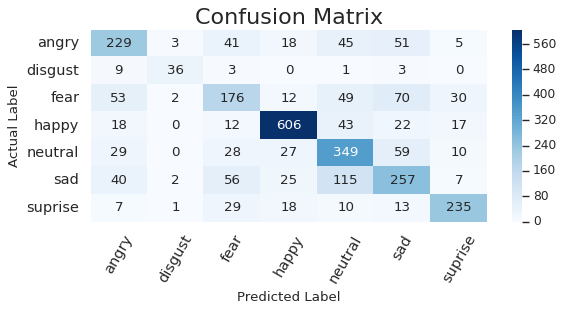

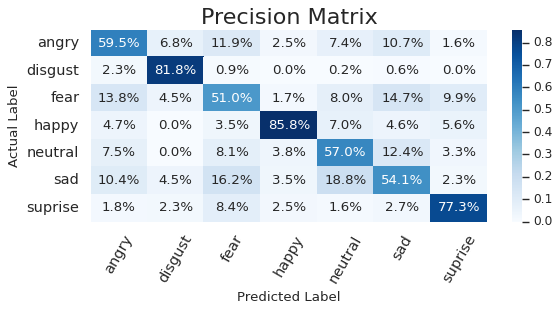

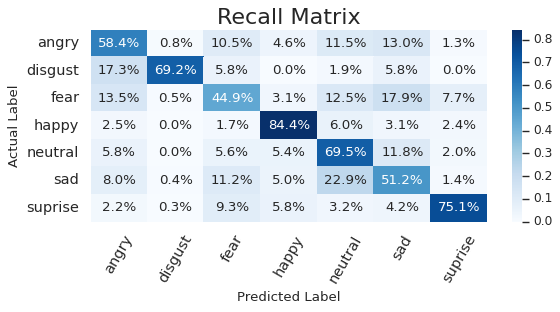

In [ ]:
preds = np.argmax(model.predict(test_X), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
return_confusion_matrix(test_y,preds)

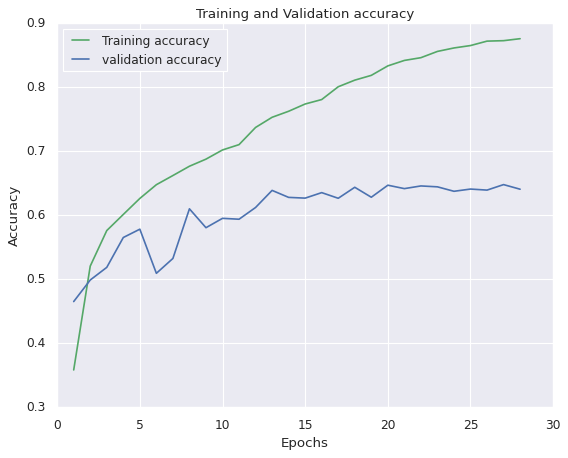

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,len(acc_train)+1)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

### Weighted Class Approach

In [ ]:
#weighted class approach
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_y),
                                                 train_y)
class_weights = dict(enumerate(class_weights))

model = model
model.set_weights(initial_weights)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=['accuracy'])

# reduce learning rate when loss on validation set has stopped improving
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=3, verbose=1)

#stop training when loss on validation set has stopped improving
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')

checkpointer = ModelCheckpoint(filepath='model.lab32.hdf5',
                               verbose=1,save_best_only=True, monitor='val_loss')

history = model.fit(train_gen,
          epochs=50,
          verbose=1,
          validation_data=(validation_X, y_validation),
          shuffle=True,
          class_weight = class_weights,
          callbacks=[lr_reducer, early_stopper, checkpointer])


Epoch 1/50
897/898 [============================>.] - ETA: 0s - loss: 1.9432 - accuracy: 0.1861
Epoch 00001: val_loss improved from inf to 2.06169, saving model to model.lab32.hdf5
898/898 [==============================] - 11s 12ms/step - loss: 1.9430 - accuracy: 0.1862 - val_loss: 2.0617 - val_accuracy: 0.1725
Epoch 2/50
898/898 [==============================] - ETA: 0s - loss: 1.7680 - accuracy: 0.3156
Epoch 00002: val_loss improved from 2.06169 to 1.75793, saving model to model.lab32.hdf5
898/898 [==============================] - 10s 11ms/step - loss: 1.7680 - accuracy: 0.3156 - val_loss: 1.7579 - val_accuracy: 0.2679
Epoch 3/50
897/898 [============================>.] - ETA: 0s - loss: 1.5980 - accuracy: 0.3800
Epoch 00003: val_loss improved from 1.75793 to 1.67059, saving model to model.lab32.hdf5
898/898 [==============================] - 10s 11ms/step - loss: 1.5980 - accuracy: 0.3800 - val_loss: 1.6706 - val_accuracy: 0.3585
Epoch 4/50
896/898 [============================>.


Accuracy on Test Data:  0.6374085684430512


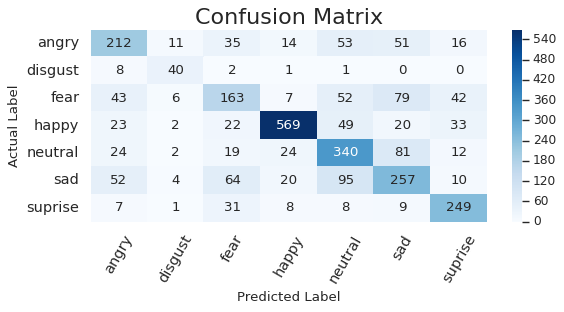

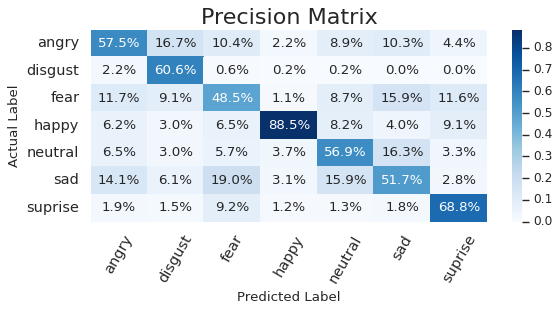

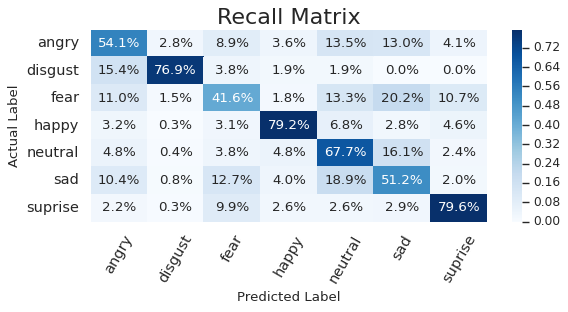

In [ ]:
preds = np.argmax(model.predict(test_X), axis=1)
print("\nAccuracy on Test Data: ", accuracy_score(test_y, preds))
return_confusion_matrix(test_y,preds)

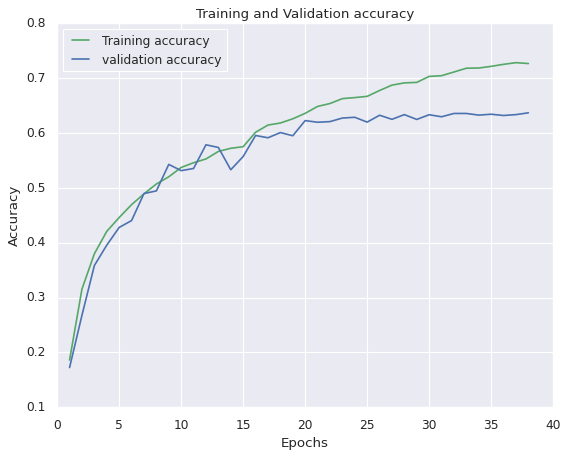

In [ ]:
acc_train = history.history['accuracy']
acc_val = history.history['val_accuracy']
epochs = range(1,len(acc_train)+1)
plt.plot(epochs, acc_train, 'g', label='Training accuracy')
plt.plot(epochs, acc_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.show()

### Tests on celebrity images

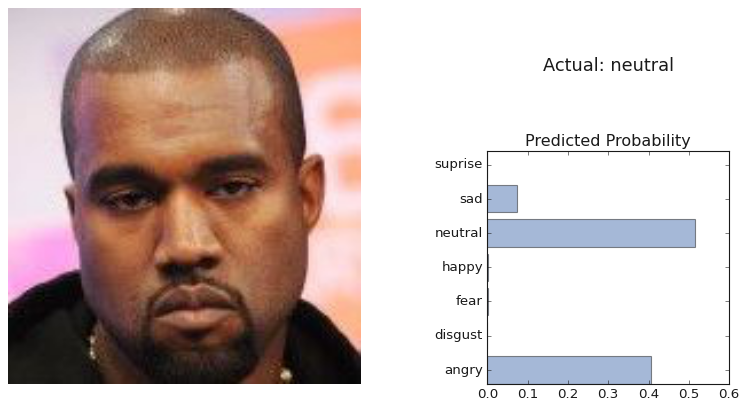

In [ ]:
#test on image from folder
return_prediction('Test Images/neutral/kanye.jpg', model)

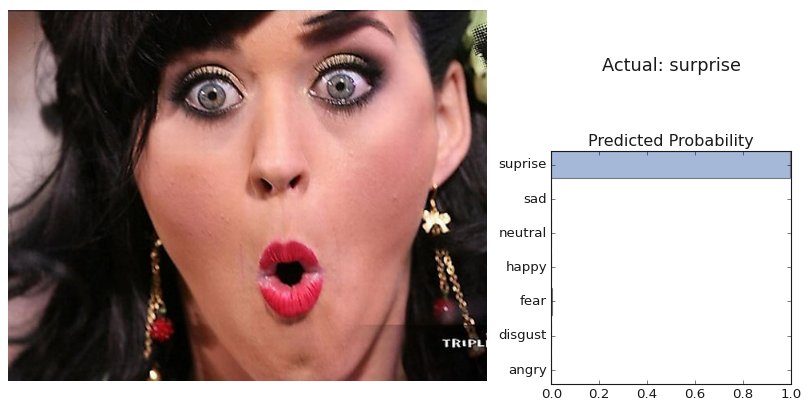

In [ ]:
return_prediction('Test Images/surprise/katy.jpg', model)

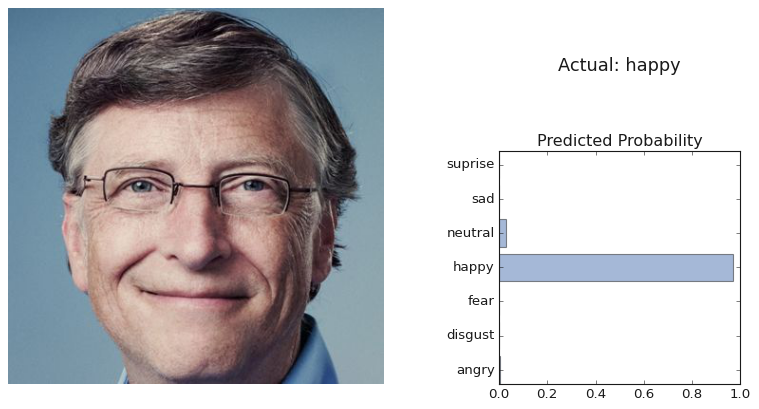

In [ ]:
#test on image from folder
return_prediction('Test Images/happy/gates.jpeg', model)

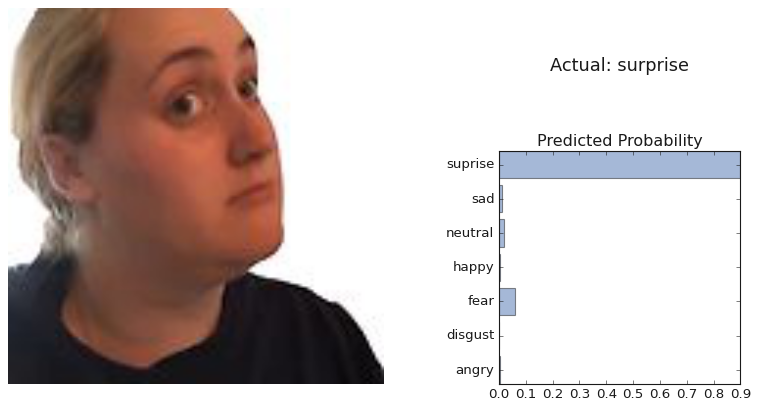

In [ ]:
return_prediction('Test Images/surprise/kambucha.jpg', model)